In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Triazines

In [2]:
from sklearn.datasets import fetch_openml

# Triazines dataset from UCI
triazines = fetch_openml(name='triazines', version=1, as_frame=True)
X = triazines.data
y = triazines.target

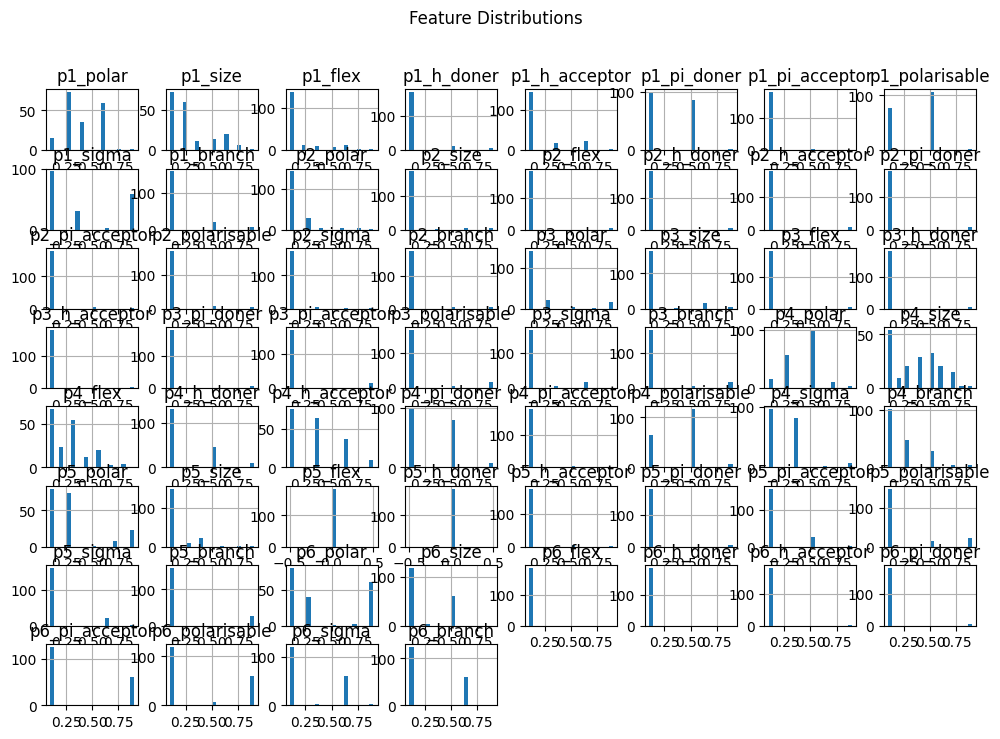

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

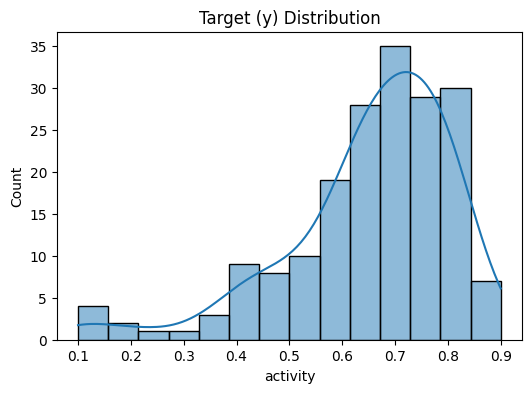

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

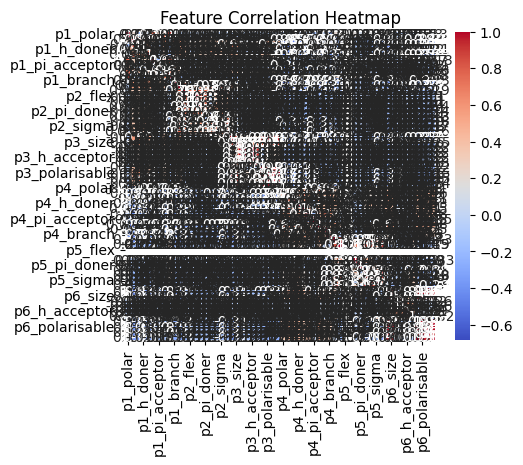

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.179944                 1.076312             1.115513   
1                  1.368626                 1.050453             1.213410   
2                  1.043659                 1.038839             1.034575   
3                  1.078922                 1.054620             1.013811   
4                  1.228338                 1.057156             1.174375   
mean               1.179898                 1.055476             1.110337   
std                0.129153                 0.013599             0.086326   

      DefaultBART_Rhat_RMSE  
0                  1.047221  
1                  1.259303  
2                  1.046507  
3                  1.101367  
4                  1.058722  
mean               1.102624  
std                0.090410  


In [8]:
rhat_df.to_csv("results/real8_Triazines_rhat.csv", index=False)

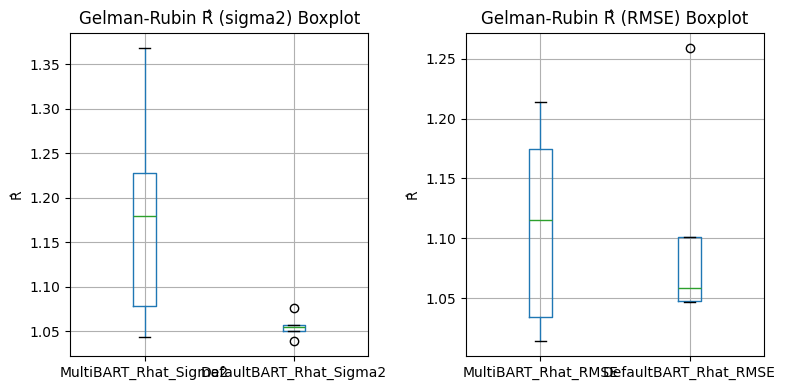

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-09-25 03:17:35,946:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-09-25 03:17:36,571:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-09-25 03:17:44,749:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.021657  0.021325  0.020500  0.020100  0.022165
1      0.014649  0.015242  0.016704  0.010456  0.008847
2      0.017278  0.022982  0.016166  0.015804  0.022521
3      0.018085  0.021442  0.015372  0.019007  0.027133
4      0.018838  0.017066  0.014538  0.016437  0.018578
5      0.021692  0.022294  0.026063  0.019980  0.023882
6      0.021279  0.017270  0.012565  0.019972  0.022427
7      0.015945  0.018927  0.019039  0.017551  0.017660
8      0.007947  0.007168  0.011470  0.007863  0.010011
9      0.010923  0.011440  0.010183  0.009424  0.013731
mean   0.016829  0.017516  0.016260  0.015659  0.018695
std    0.004617  0.005100  0.004706  0.004704  0.006118



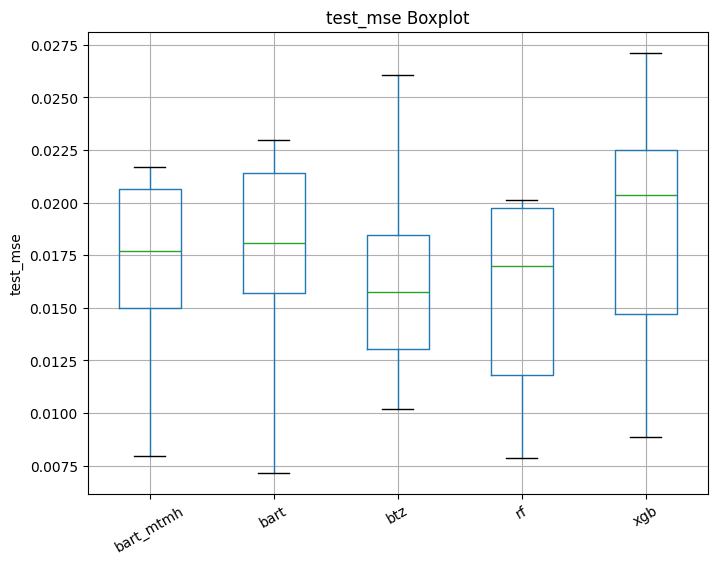

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.013165  0.011051  0.011298  0.001889  0.000017
1      0.010719  0.012855  0.014471  0.002761  0.000335
2      0.009799  0.012930  0.013332  0.002411  0.000320
3      0.007572  0.010693  0.013760  0.001884  0.000047
4      0.009507  0.012868  0.014092  0.002145  0.000333
5      0.007374  0.010829  0.012255  0.002086  0.000362
6      0.009735  0.011700  0.014201  0.001827  0.000055
7      0.006481  0.013237  0.012210  0.002243  0.000323
8      0.011434  0.013860  0.015769  0.003117  0.000359
9      0.012978  0.014265  0.015293  0.002526  0.000072
mean   0.009876  0.012429  0.013668  0.002289  0.000222
std    0.002281  0.001278  0.001415  0.000419  0.000151



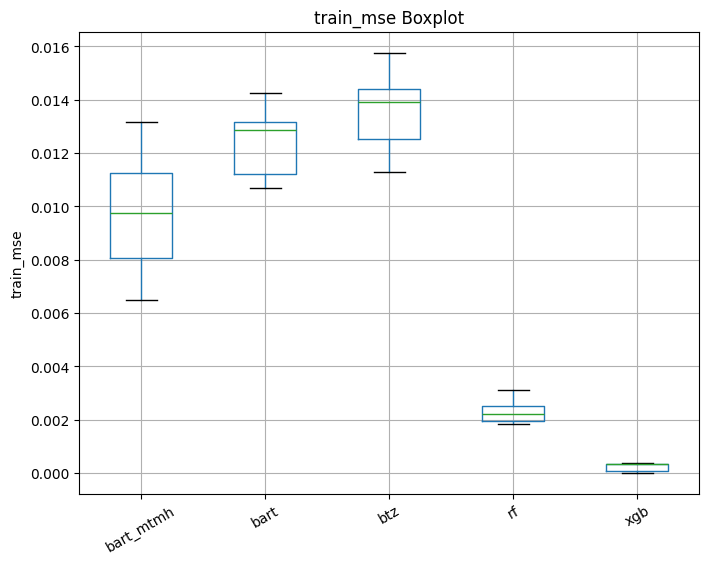

pi_length:
      bart_mtmh      bart       btz
0      0.502345  0.486473  0.495119
1      0.541118  0.524527  0.546341
2      0.517615  0.497363  0.523382
3      0.483904  0.488438  0.531048
4      0.499873  0.526082  0.534375
5      0.473535  0.484467  0.498798
6      0.490269  0.513094  0.541870
7      0.454899  0.505156  0.505294
8      0.551110  0.538903  0.560880
9      0.539332  0.546731  0.565304
mean   0.505400  0.511124  0.530241
std    0.031557  0.022373  0.024658



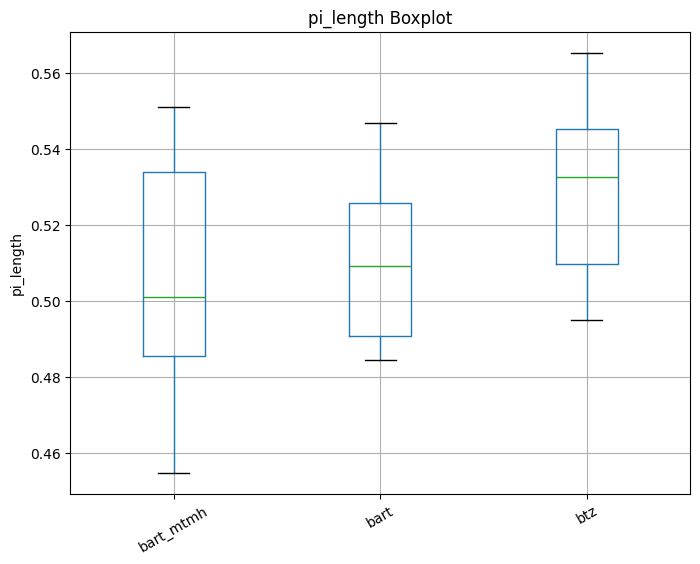

coverage:
      bart_mtmh      bart       btz
0      0.957447  0.914894  0.893617
1      0.936170  0.936170  0.936170
2      0.957447  0.936170  0.957447
3      0.914894  0.893617  0.936170
4      0.957447  0.957447  0.978723
5      0.872340  0.872340  0.893617
6      0.914894  0.936170  0.978723
7      0.936170  0.957447  0.936170
8      1.000000  1.000000  0.978723
9      0.978723  0.978723  1.000000
mean   0.942553  0.938298  0.948936
std    0.036233  0.038127  0.036440



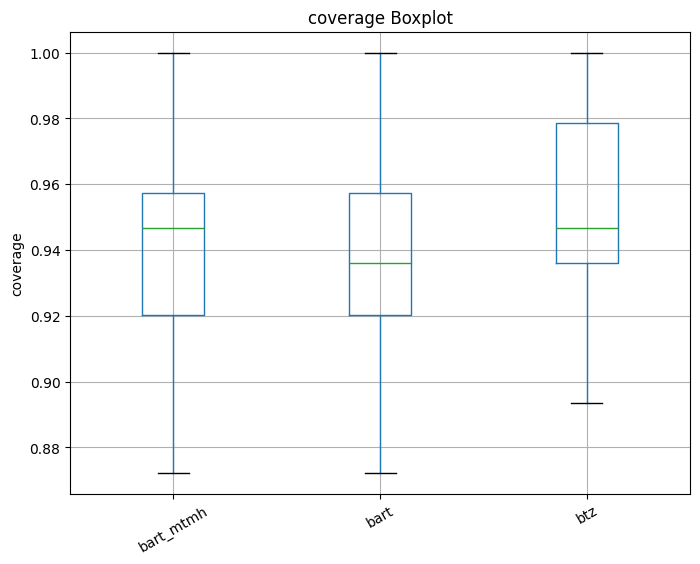

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     144.946947  16.324178  18.056585  0.207440  0.175824
1     141.749132  16.837230  17.970695  0.202253  0.170841
2     134.840476  15.532832  16.259316  0.199844  0.175396
3     142.014254  17.592292  17.880829  0.205591  0.177240
4     134.484570  15.228806  16.533639  0.220272  0.190508
5     157.531636  18.732623  18.666399  0.200833  0.175725
6     148.853776  15.508281  16.666268  0.222241  0.808181
7     150.000044  16.814063  18.079894  0.239412  0.177986
8     144.851501  16.317954  17.492839  0.209874  0.175307
9     145.497266  16.749092  17.734520  0.202855  0.173249
mean  144.476960  16.563735  17.534098  0.211061  0.240026
std     6.893663   1.054641   0.787741  0.012620  0.199697



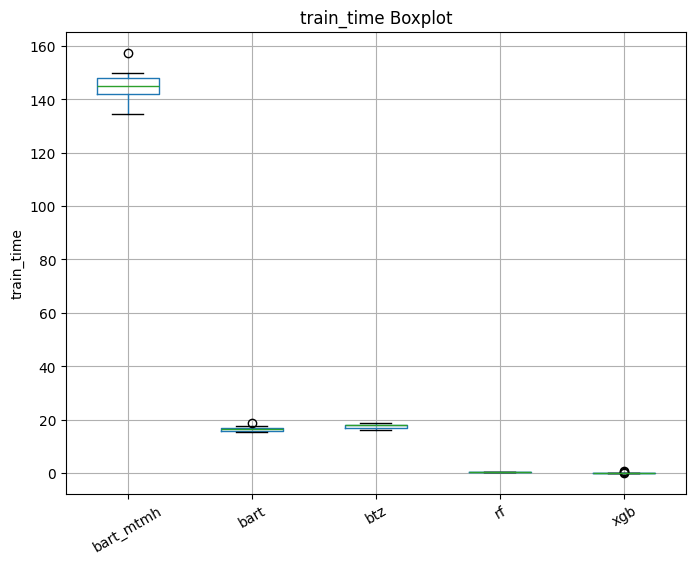

In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [11]:
for k, v in mse_results.items():
    csv_name = f"results/real8_Triazines_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [12]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real8_Triazines_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real8_Triazines_tries.csv", index=False)

In [13]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage  Train_Time
0            1     1.056164   1.074348  0.019315  0.914894   24.751038
1            5     1.073784   1.041044  0.019022  0.936170   71.704651
2           10     1.179898   1.110337  0.017583  0.940426  145.002621
3           50     1.104385   1.065203  0.017577  0.931915  808.274351
